## Run ICA

Use ICA to remove ocular and cardiac artifacts from the concatenated, Maxwell-filtered MEG data. After loading `*_ALL_sss_raw.fif`, bad channels from `{subject}_bads.txt` are excluded, data are bandpass filtered 1–200 Hz and 60 Hz-notch filtered, then ICA is fit on MEG channels. Artifact components are identified automatically by correlating component time courses with EOG (blinks/eye movements) and ECG (heartbeat), those components are excluded, and the cleaned data are reconstructed and saved as `{subject}_ALL_post_ica-raw.fif` (the ICA solution is also saved to `{subject}_ALL-ica.fif`). Below the automatic pipeline, you can optionally review component topographies/time courses and adjust exclusions manually before applying.

*The final ICA-cleaned data saved at `{subject}_ALL_post_ica-raw.fif` should be used for all analyses going forward.*

In [1]:
# load packages
import numpy as np
import os
import time
import mne
from mne.io import read_raw_fif
from mne.preprocessing import ICA, read_ica
%matplotlib inline

In [2]:
# subject info
subjects = ['nbl_004', 'nbl_005']
sessions = ['01']

# filter params
filt_l, filt_h = 1, 200
filt_notch = 60

# ICA params
decim = 5
reject = dict(mag=5e-12, grad=4e-10)
random_state = 42
max_iter = 10000

In [3]:
# fit ICA for all subjects/sessions in list
for subject in subjects:
    for ses in sessions:
        # file paths
        meg_dir = os.path.join('/mnt/sphere/nbl/processed_meg/', subject, 'ses-'+ses)
        raw_fname = os.path.join(meg_dir, f"{subject}_ALL_sss_raw.fif")
        ica_solution_fname = os.path.join(meg_dir, f"{subject}_ALL-ica.fif")
        ica_processed_fname = os.path.join(meg_dir, f"{subject}_ALL_post_ica-raw.fif")  # ICA applied to raw data
        bads_list_fname = os.path.join(meg_dir, f"{subject}_bads.txt")
        if not os.path.exists(bads_list_fname):
            raise FileNotFoundError(f"Bad channels file not found: {bads_list_fname}. Go back and make it.")
        with open(bads_list_fname, 'r') as f: bads = [line.strip() for line in f.readlines()]
        
        ### SECTION 1: Fitting the ICA solution ###
        print(f"Reading raw file for {subject}...")
        t = time.time()
        raw = read_raw_fif(raw_fname, preload=True, verbose=True)
        elapsed_readraw = time.time() - t
        print(f"Loaded in {elapsed_readraw:.1f} seconds.\n")

        print("Excluding bad channels...")
        raw.info['bads'] = bads
        print('Bad channels:', bads)
        raw.pick(picks='all', exclude='bads')
        raw.info.normalize_proj()
    
        print("Filtering data...")
        raw = raw.filter(filt_l, filt_h, picks='meg', n_jobs=-1)
        raw = raw.notch_filter(filt_notch, picks='meg', n_jobs=-1)
    
        print("Creating ICA object...")
        ica = ICA(n_components=0.95, method='picard', max_iter=max_iter, random_state=random_state)
    
        print("Fitting ICA...")
        t = time.time()
        ica.fit(raw, decim=decim, reject=reject, picks='meg')
        elapsed_ica = (time.time() - t)/60
        print("ICA fit elapsed time in minutes: %s" %elapsed_ica)
    
        print("Saving ICA solution...")
        ica.save(ica_solution_fname, overwrite=True)  # save solution
    
        ### SECTION 2: Applying the ICA solution ###
        # EOG and ECG adjustments
        ica.exclude = []
        # find which ICs match the EOG and ECG pattern
        print("Finding EOG scores...")
        eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name='EOG001')
        print("Finding ECG scores...")
        ecg_indices, ecg_scores = ica.find_bads_ecg(raw, ch_name='ECG002')
    
        eog_ecg_indices = eog_indices + ecg_indices
        ica.exclude = eog_ecg_indices # this modifies the ICA object in place and preps it for the ICA application in the next step
    
        # apply the ICA solution to the raw data and save it
        print("Applying ICA...")
        ica.apply(raw)
        raw.save(ica_processed_fname, overwrite=True)
        print(f"ICA applied and saved for {subject}\n\n")

Reading raw file for nbl_004...
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw.fif...
    Range : 18000 ... 1678999 =     18.000 ...  1678.999 secs
Ready.
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw-1.fif...
    Range : 1679000 ... 3339999 =   1679.000 ...  3339.999 secs
Ready.
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw-2.fif...
    Range : 3340000 ... 5000999 =   3340.000 ...  5000.999 secs
Ready.
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw-3.fif...
    Range : 5001000 ... 6263999 =   5001.000 ...  6263.999 secs
Ready.
Reading 0 ... 6245999  =      0.000 ...  6245.999 secs...
Loaded in 29.3 seconds.

Excluding bad channels...
Bad channels: ['MEG1132', 'MEG1543', 'MEG1843']
Filtering data...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
----------------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   30.6s finished


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   26.0s finished


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   14.4s finished


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   28.3s finished


Creating ICA object...
Fitting ICA...
Fitting ICA to data using 303 channels (please be patient, this may take a while)
    Rejecting  epoch based on MAG : ['MEG0131']
Artifact detected in [75200, 75600]
    Rejecting  epoch based on MAG : ['MEG0131']
Artifact detected in [90400, 90800]
    Rejecting  epoch based on MAG : ['MEG0121', 'MEG0131', 'MEG0211']
Artifact detected in [143200, 143600]
    Rejecting  epoch based on MAG : ['MEG0131']
Artifact detected in [143600, 144000]
    Rejecting  epoch based on MAG : ['MEG0111', 'MEG0121', 'MEG0131', 'MEG0141', 'MEG0211', 'MEG0311', 'MEG1511', 'MEG1521', 'MEG2611']
Artifact detected in [144000, 144400]
    Rejecting  epoch based on MAG : ['MEG0131']
Artifact detected in [148400, 148800]
    Rejecting  epoch based on MAG : ['MEG1411', 'MEG1441']
Artifact detected in [157600, 158000]
    Rejecting  epoch based on MAG : ['MEG0111', 'MEG0121', 'MEG1421']
Artifact detected in [161600, 162000]
    Rejecting  epoch based on MAG : ['MEG0111', 'MEG0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    6.6s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Finding ECG scores...
Using threshold: 0.16 for CTPS ECG detection
Using channel ECG002 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   24.3s finished


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   17.6s finished


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   12.9s finished


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   16.9s finished


Creating ICA object...
Fitting ICA...
Fitting ICA to data using 303 channels (please be patient, this may take a while)
    Rejecting  epoch based on MAG : ['MEG0121']
Artifact detected in [24400, 24800]
    Rejecting  epoch based on MAG : ['MEG0121']
Artifact detected in [42400, 42800]
    Rejecting  epoch based on MAG : ['MEG0111', 'MEG0121']
Artifact detected in [60000, 60400]
    Rejecting  epoch based on MAG : ['MEG1311', 'MEG1521']
Artifact detected in [65600, 66000]
    Rejecting  epoch based on MAG : ['MEG1331', 'MEG2421', 'MEG2431', 'MEG2611', 'MEG2641']
Artifact detected in [66000, 66400]
    Rejecting  epoch based on MAG : ['MEG2421', 'MEG2431', 'MEG2521', 'MEG2611', 'MEG2641']
Artifact detected in [66400, 66800]
    Rejecting  epoch based on MAG : ['MEG0111', 'MEG0121']
Artifact detected in [102000, 102400]
    Rejecting  epoch based on MAG : ['MEG0221', 'MEG0241', 'MEG0321', 'MEG1311', 'MEG1321', 'MEG1331', 'MEG1341', 'MEG1511', 'MEG1521', 'MEG1611', 'MEG1621', 'MEG1641', 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    5.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Finding ECG scores...
Using threshold: 0.16 for CTPS ECG detection
Using channel ECG002 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper tra

### Option to manually review ICA components

Follow the steps below to apply each individual ICA solution and select bad compoenents via EOG and ECG channels

In [4]:
# subject info
subject = 'nbl_004'
session = '01'

# file paths
meg_dir = os.path.join('/mnt/sphere/nbl/processed_meg/', subject, 'ses-'+session)
raw_fname = os.path.join(meg_dir, f"{subject}_ALL_sss_raw.fif")
ica_solution_fname = os.path.join(meg_dir, f"{subject}_ALL-ica.fif")
ica_processed_fname = os.path.join(meg_dir, f"{subject}_ALL_post_ica-raw.fif")  # ICA applied to raw data
bads_list_fname = os.path.join(meg_dir, f"{subject}_bads.txt")
if not os.path.exists(bads_list_fname):
    raise FileNotFoundError(f"Bad channels file not found: {bads_list_fname}. Go back and make it.")
with open(bads_list_fname, 'r') as f: bads = [line.strip() for line in f.readlines()]

In [6]:
## load in raw data, remove bad channels, and load in ICA solution
print(f"Reading raw file for {subject}...")
t = time.time()
raw = read_raw_fif(raw_fname, preload=True, verbose=True)
elapsed_readraw = time.time() - t
print(f"Loaded in {elapsed_readraw:.1f} seconds.\n")

print("Excluding bad channels...")
raw.info['bads'] = bads
print('Bad channels:', bads)
raw.pick(picks='all', exclude='bads')
raw.info.normalize_proj()

print("\nFiltering data...")
raw = raw.filter(filt_l, filt_h, picks='meg', n_jobs=-1)
raw = raw.notch_filter(filt_notch, picks='meg', n_jobs=-1)

print ("\nReading ICA solution...")
ica = read_ica(ica_solution_fname)

Reading raw file for nbl_004...
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw.fif...
    Range : 18000 ... 1678999 =     18.000 ...  1678.999 secs
Ready.
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw-1.fif...
    Range : 1679000 ... 3339999 =   1679.000 ...  3339.999 secs
Ready.
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw-2.fif...
    Range : 3340000 ... 5000999 =   3340.000 ...  5000.999 secs
Ready.
Opening raw data file /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL_sss_raw-3.fif...
    Range : 5001000 ... 6263999 =   5001.000 ...  6263.999 secs
Ready.
Reading 0 ... 6245999  =      0.000 ...  6245.999 secs...
Loaded in 23.5 seconds.

Excluding bad channels...
Bad channels: ['MEG1132', 'MEG1543', 'MEG1843']
Filtering data...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
----------------

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   27.4s finished


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   21.9s finished


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   14.3s finished


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 303 out of 303 | elapsed:   25.8s finished


Reading ICA solution...
Reading /mnt/sphere/nbl/processed_meg/nbl_004/ses-01/nbl_004_ALL-ica.fif ...
Now restoring ICA solution ...
Ready.


Creating RawArray with float64 data, n_channels=44, n_times=6246000
    Range : 18000 ... 6263999 =     18.000 ...  6263.999 secs
Ready.
Using matplotlib as 2D backend.


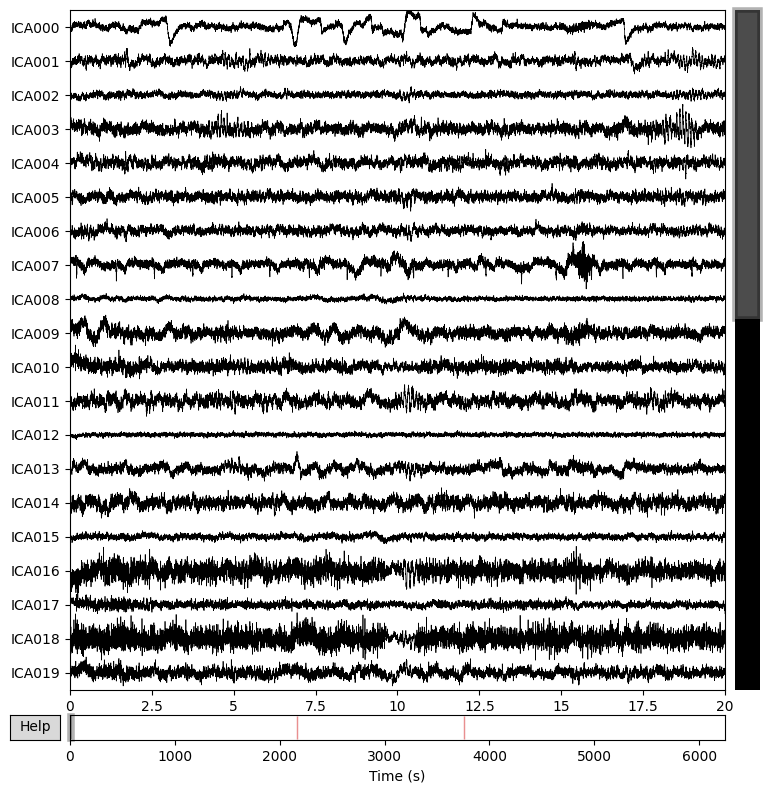

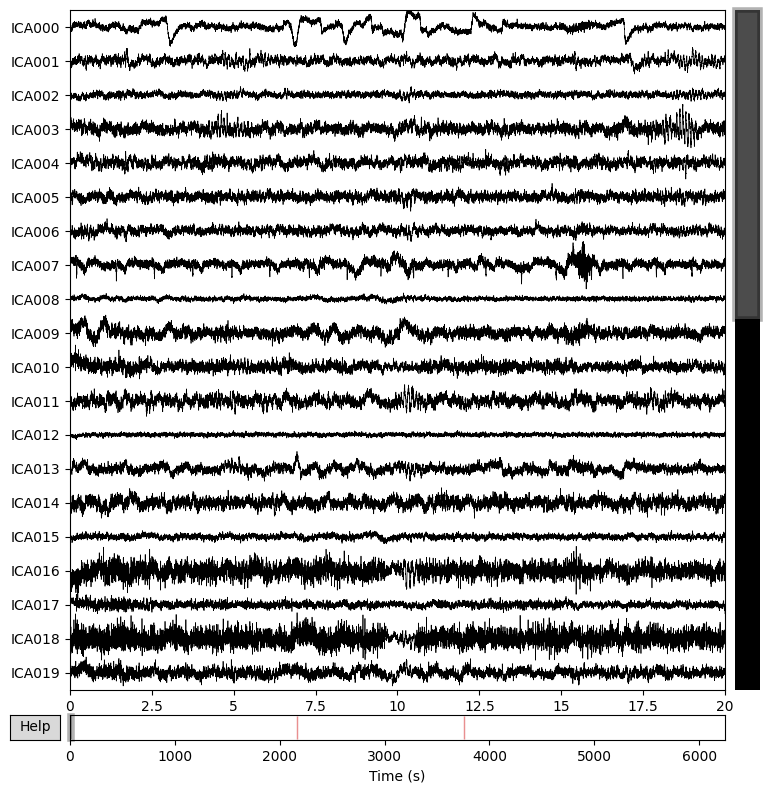

In [7]:
# plot ICA without EOG or ECG adjustments
ica.plot_sources(raw)

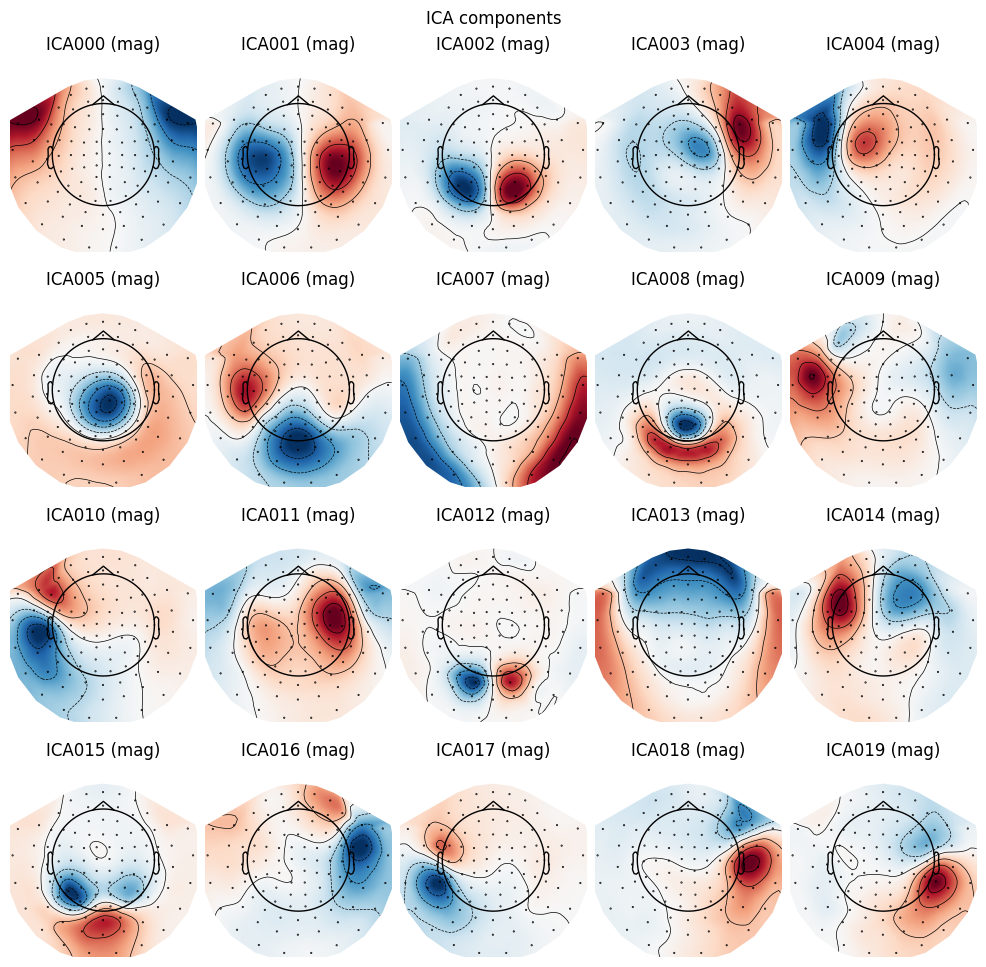

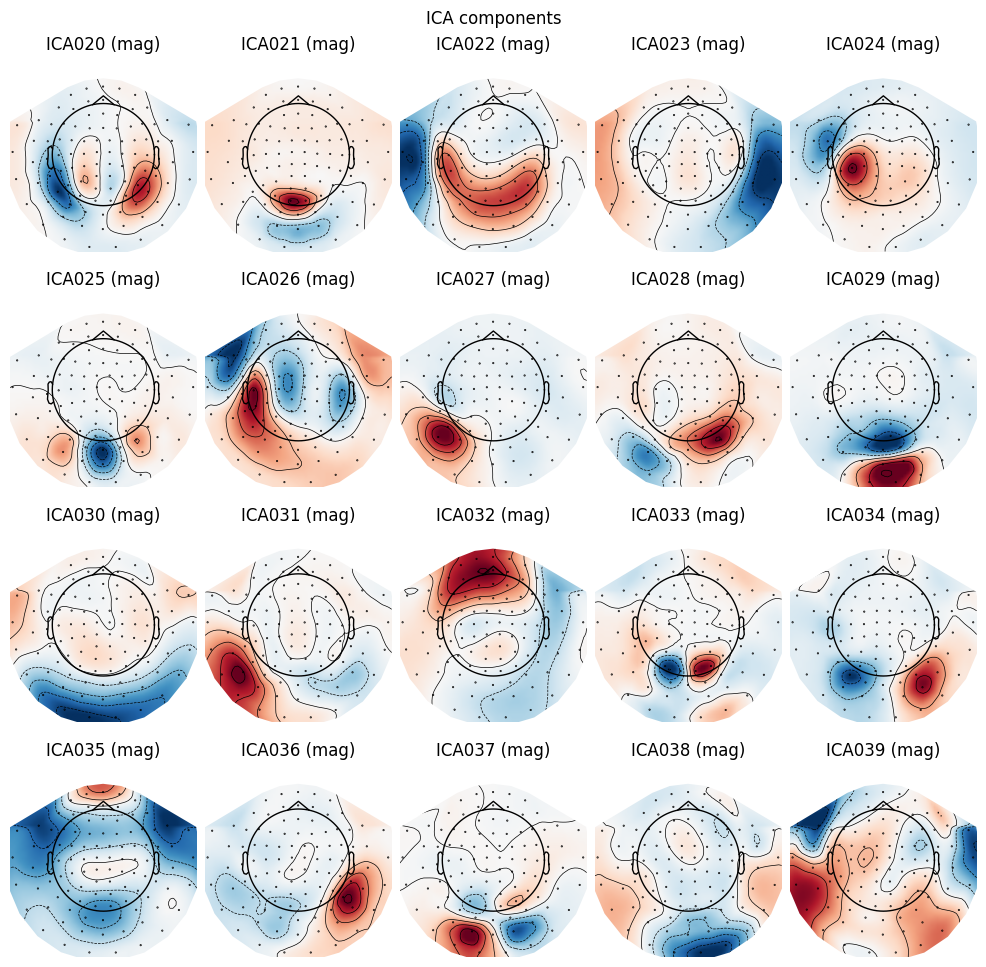

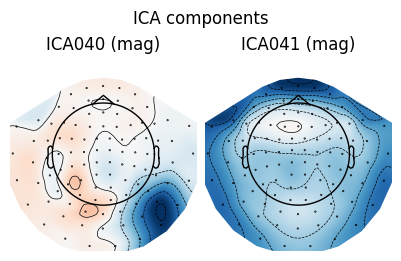

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 390x260.5 with 2 Axes>]

In [8]:
# plot components of the ICA
ica.plot_components()

In [12]:
# EOG and ECG adjustments
print("Finding EOG scores...")
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name='EOG001')
print("Finding ECG scores...")
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, ch_name='ECG002')

Finding EOG scores...
Using EOG channel: EOG001
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    6.1s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Finding ECG scores...
Using threshold: 0.16 for CTPS ECG detection
Using channel ECG002 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper tra

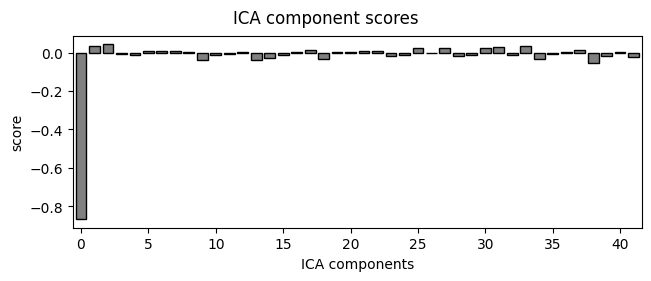

In [16]:
# EOG checks: barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores);

Applying ICA to Raw instance
    Transforming to ICA space (42 components)
    Zeroing out 1 ICA component
    Projecting back using 303 PCA components


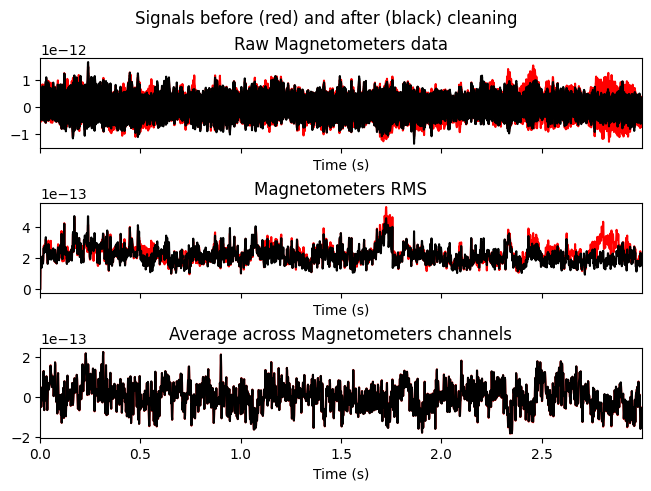

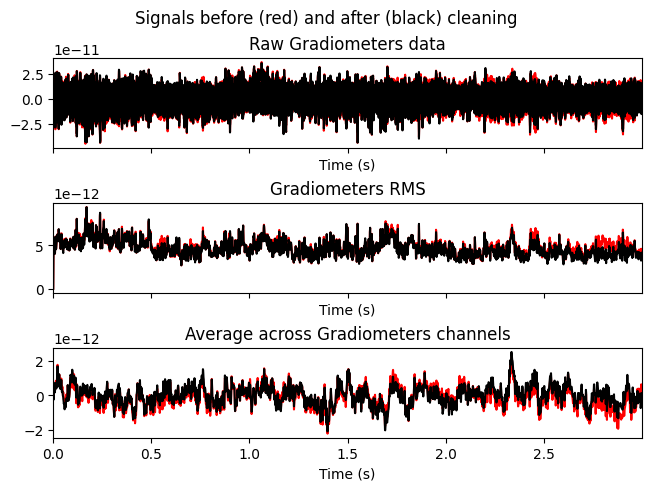

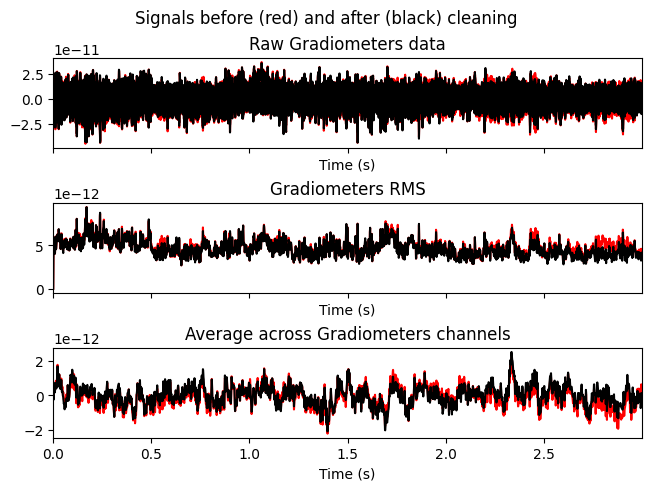

In [19]:
# blinks
ica.plot_overlay(raw, exclude=[0], picks="meg")

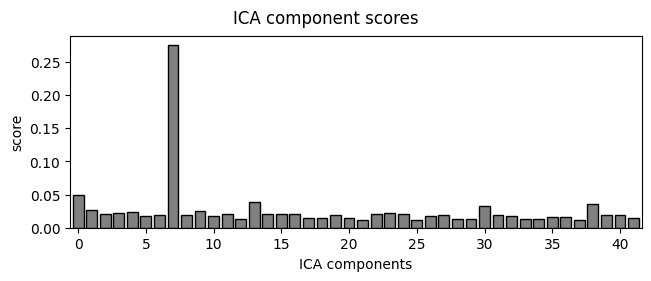

In [17]:
# ECG checks: barplot of ICA component "ECG match" scores
ica.plot_scores(ecg_scores);

Applying ICA to Raw instance
    Transforming to ICA space (42 components)
    Zeroing out 1 ICA component
    Projecting back using 303 PCA components


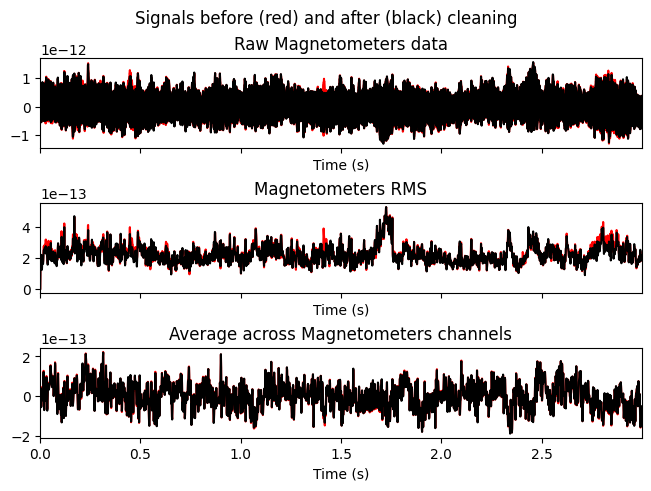

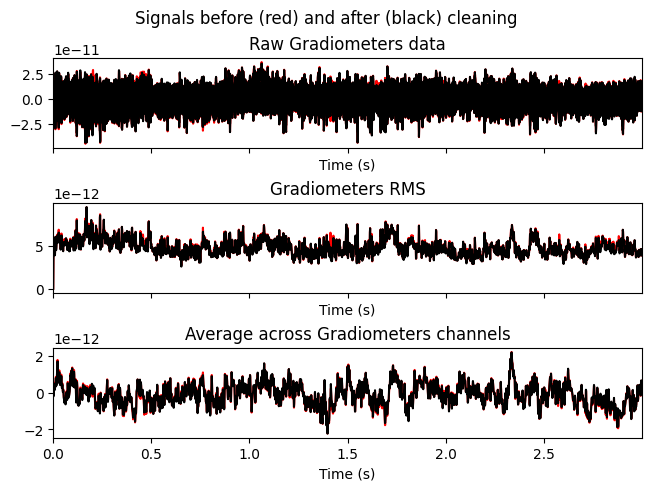

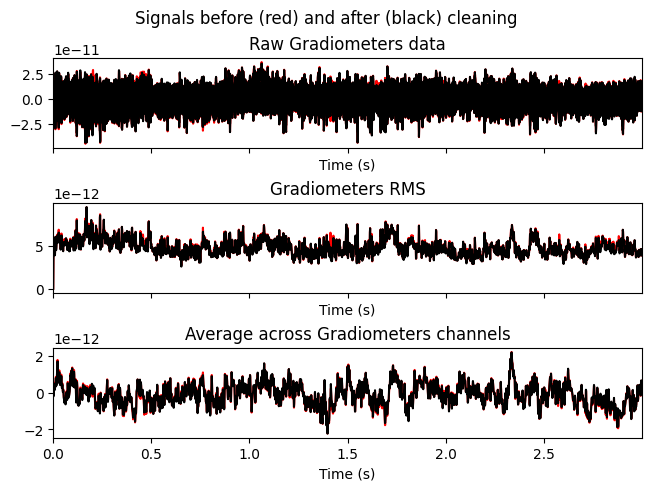

In [18]:
# heartbeats
ica.plot_overlay(raw, exclude=[7], picks="meg")

In [15]:
# add up the indices and add them as exclusions to the ICA
eog_ecg_indices = eog_indices + ecg_indices
ica.exclude = eog_ecg_indices

# copy over the raw without ICA so you can then apply and compare below
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (164 components)
    Zeroing out 6 ICA components
    Projecting back using 304 PCA components


<Raw | nbl_002_buckeye_passive_raw.fif, 317 x 2722000 (2722.0 s), ~6.44 GiB, data loaded>

In [16]:
# check the raw data against the new cleaned data
%matplotlib qt
raw.plot()

/tmp/ipykernel_967869/575594068.py:3: RuntimeWarning: Projection vector 'generated with dossp-2.1' has been reduced to 66.18% of its original magnitude by subselecting 304/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  raw.plot()


Channels marked as bad:
none


In [17]:
# check the raw data against the new cleaned data
%matplotlib qt
reconst_raw.plot()

/tmp/ipykernel_967869/1498205876.py:3: RuntimeWarning: Projection vector 'generated with dossp-2.1' has been reduced to 66.18% of its original magnitude by subselecting 304/204 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  reconst_raw.plot()


Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [ ]:
# apply the ICA solution to the raw data and save it
ica.apply(raw)
raw.save(ica_processed_fname, overwrite=True)